# Data Science Test - Ming Li

## Exploratory Data Analysis

In [1]:
import json
from functools import partial

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

In [337]:
import pyro
import torch

from torch import nn
from torch.nn import BCELoss

from pyro.optim import Adam
from pyro.infer import Trace_ELBO, SVI, TracePredictive, EmpiricalMarginal
from pyro.infer.mcmc.util import summary

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.distributions import Normal, Bernoulli, Delta

In [6]:
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 100

In [7]:
df_raw_cust = pd.read_csv("./customer-data.csv")

In [8]:
df_raw_cust.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
id                     10000 non-null int64
age                    10000 non-null object
gender                 10000 non-null object
race                   10000 non-null object
driving_experience     10000 non-null object
education              10000 non-null object
income                 10000 non-null object
credit_score           9018 non-null float64
vehicle_ownership      10000 non-null bool
vehicle_year           10000 non-null object
married                10000 non-null bool
children               10000 non-null bool
postal_code            10000 non-null int64
annual_mileage         9043 non-null float64
vehicle_type           10000 non-null object
speeding_violations    10000 non-null int64
DUIs                   10000 non-null int64
past_accidents         10000 non-null int64
outcome                10000 non-null bool
dtypes: bool(4), float64(2), int64(5), object(8)
m

In [9]:
df_raw_cust.head().transpose()

,0,1,2,3,4
id,569520,750365,199901,478866,731664
age,65+,16-25,16-25,16-25,26-39
gender,female,male,female,male,male
race,majority,majority,majority,majority,majority
driving_experience,0-9y,0-9y,0-9y,0-9y,10-19y
education,high school,none,high school,university,none
income,upper class,poverty,working class,working class,working class
credit_score,0.629027,0.357757,0.493146,0.206013,0.388366
vehicle_ownership,True,False,True,True,True
vehicle_year,after 2015,before 2015,before 2015,before 2015,before 2015


In [10]:
df_raw_cust.loc[:, "outcome"].value_counts()

False    6867
True     3133
Name: outcome, dtype: int64

### Q1. what proportion of customers with credit_score under .2 made a claim?

In [11]:
df_score_claim = df_raw_cust.loc[:, ["credit_score", "outcome"]].copy()

In [12]:
# p(claim | c < .2) = p(claim, c < .2) / p(c < .2)
joint = df_score_claim.loc[(df_score_claim["outcome"]) & (df_score_claim["credit_score"] < .2)]
z = df_score_claim.loc[df_score_claim["credit_score"] < .2]

In [13]:
# conditional
joint.shape[0] / z.shape[0]

0.6020408163265306

### Q2. average number of speeding violations 20 - 29 years of driving? what if sport cars only in this group?

In [14]:
df_speeding_20_29 = df_raw_cust.loc[df_raw_cust["driving_experience"] == "20-29y", ["speeding_violations", "vehicle_type"]]

In [15]:
df_speeding_20_29["speeding_violations"].mean()

2.734308636149127

In [16]:
df_speeding_20_29.loc[df_speeding_20_29["vehicle_type"] == "sports car", "speeding_violations"].mean()

2.7777777777777777

### Q3. what's the annual mileage standard deviation?

In [17]:
df_raw_cust["annual_mileage"].std()

2818.434528301786

In [18]:
df_cust = df_raw_cust.drop("id", axis=1).dropna()

In [19]:
transformation_dict = {}
# turn categorical features into numerical values
multinominal = []
df_cust["postal_code"] = df_cust["postal_code"].astype("object")
for col in df_cust.select_dtypes(include=["object"]):
    df_cust.loc[:, col] = df_cust.loc[:, col].astype("category")
    if len(df_cust.loc[:, col].cat.categories) > 2:
        multinominal.append(col)

    transformation_dict.update(
        {col: {k: v for (v, k) in enumerate(df_cust.loc[:, col].cat.categories)}})

for col in df_cust.select_dtypes(include=["bool"]):
    df_cust.loc[:, col] = df_cust.loc[:, col].astype(int)

transformation_dict.update(
    {"education": {"none": 0, "high school": 1, "university": 2},
     "income": {'middle class': 2, "poverty": 0, "upper class": 3, "working class": 1}})

In [20]:
print(json.dumps(transformation_dict, indent=4))

{
    "age": {
        "16-25": 0,
        "26-39": 1,
        "40-64": 2,
        "65+": 3
    },
    "gender": {
        "female": 0,
        "male": 1
    },
    "race": {
        "majority": 0,
        "minority": 1
    },
    "driving_experience": {
        "0-9y": 0,
        "10-19y": 1,
        "20-29y": 2,
        "30y+": 3
    },
    "education": {
        "none": 0,
        "high school": 1,
        "university": 2
    },
    "income": {
        "middle class": 2,
        "poverty": 0,
        "upper class": 3,
        "working class": 1
    },
    "vehicle_year": {
        "after 2015": 0,
        "before 2015": 1
    },
    "postal_code": {
        "10238": 0,
        "21217": 1,
        "32765": 2,
        "92101": 3
    },
    "vehicle_type": {
        "sedan": 0,
        "sports car": 1
    }
}


In [21]:
df_cust = df_cust.replace(transformation_dict)

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=20)

In [23]:
rf.fit(df_cust.loc[:, df_cust.columns.difference(["outcome"])], df_cust["outcome"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
# feature importance per decision tree estimator
feats_imporances = np.array([rf.estimators_[i].feature_importances_ for i in range(rf.n_estimators)])
assert np.allclose(feats_imporances.mean(0), rf.feature_importances_)
feats_df = pd.DataFrame(feats_imporances, columns=df_cust.loc[:, df_cust.columns.difference(["outcome"])].columns)

Text(0.5, 1.0, 'feature importance (95% CI, n=100) using Decision Tree')

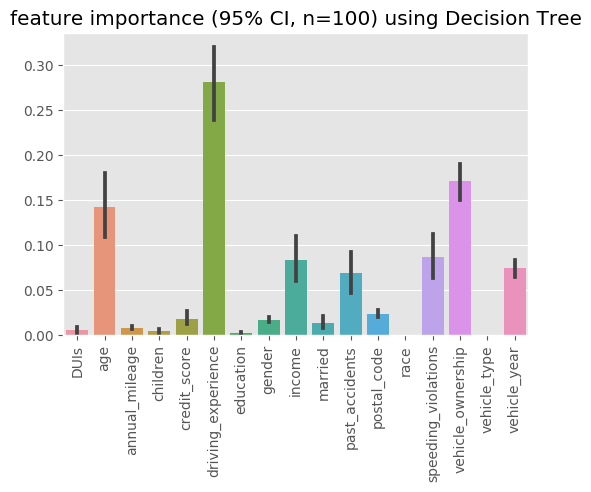

In [25]:
sns.barplot(data=feats_df, ci=95)
plt.xticks(rotation=90)
plt.title("feature importance (95% CI, n=100) using Decision Tree")

Text(0.5, 1.0, 'driving experience histogram')

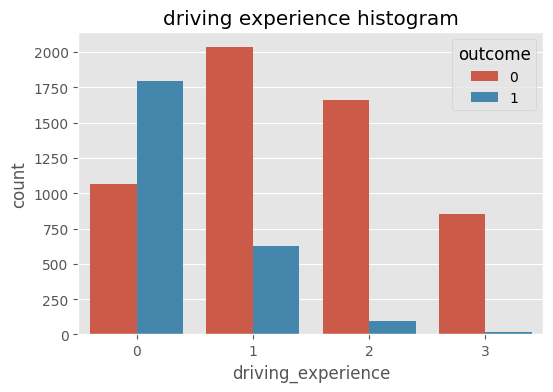

In [26]:
sns.countplot(x="driving_experience", hue="outcome", data=df_cust)
plt.title("driving experience histogram")

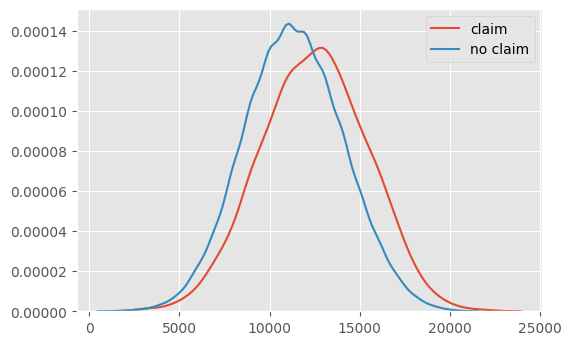

In [27]:
sns.kdeplot(df_cust["annual_mileage"][df_cust["outcome"] == 1], label="claim")
sns.kdeplot(df_cust["annual_mileage"][df_cust["outcome"] == 0], label="no claim")

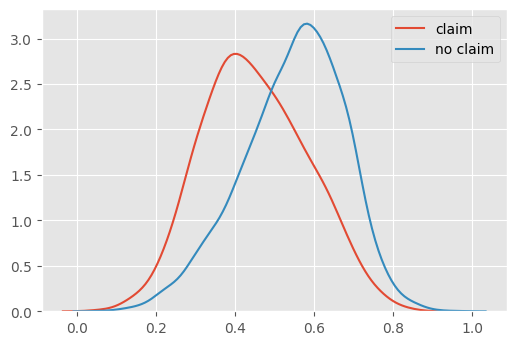

In [28]:
sns.kdeplot(df_cust["credit_score"][df_cust["outcome"] == 1], label="claim")
sns.kdeplot(df_cust["credit_score"][df_cust["outcome"] == 0], label="no claim")

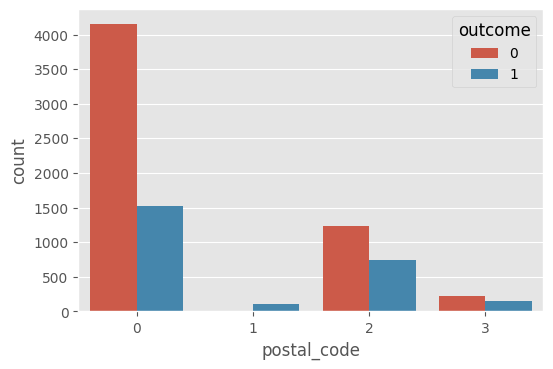

In [29]:
sns.countplot(x="postal_code", hue="outcome", data=df_cust)

In [30]:
df_cust.describe()

,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome
count,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000,8149.00000,8149.000000,8149.000000,8149.000000,8149.000000,8149.000000
mean,1.499816,0.498834,0.101362,1.076819,1.207265,1.913486,0.516368,0.699227,0.692355,0.501043,0.689287,0.639956,11693.45932,0.047613,1.485581,0.240766,1.065530,0.311204
std,1.025045,0.500029,0.301826,0.993345,0.734430,1.147985,0.137684,0.458622,0.461547,0.500030,0.462814,1.000223,2822.35147,0.212960,2.244711,0.557408,1.665623,0.463014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053358,0.000000,0.000000,0.000000,0.000000,0.000000,2000.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.417891,0.000000,0.000000,0.000000,0.000000,0.000000,10000.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.526759,1.000000,1.000000,1.000000,1.000000,0.000000,12000.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,2.000000,2.000000,3.000000,0.620074,1.000000,1.000000,1.000000,1.000000,2.000000,14000.00000,0.000000,2.000000,0.000000,2.000000,1.000000
max,3.000000,1.000000,1.000000,3.000000,2.000000,3.000000,0.960819,1.000000,1.000000,1.000000,1.000000,3.000000,22000.00000,1.000000,22.000000,6.000000,15.000000,1.000000


### toy hypothesis 1, do men and women have same likelihood to make a claim?

In [31]:
from statsmodels.stats.proportion import proportions_ztest

In [32]:
z, p = proportions_ztest(df_cust.loc[:, ["gender", "outcome"]].groupby("gender").sum()["outcome"],
                         df_cust["gender"].value_counts(),
                         value=0)
print(f"reject null hypothesis of no difference: {p < .05}")

reject null hypothesis of no difference: True


### toy hypothesis 2, do majority and minority races have same likelihood to make a claim?

In [33]:
z, p = proportions_ztest(df_cust.loc[:, ["race", "outcome"]].groupby("race").sum()["outcome"],
                         df_cust["race"].value_counts(),
                         value=0)
print(f"reject null hypothesis of no difference: {p < .05}")

reject null hypothesis of no difference: False


## Remarks following exploration
- claim dataset is only mildly unbalanced and may not require oversampling / downsampling, but worth noting.
- between "Outcome" and other variables lie an unseen causal factor i.e. car accident / scratch / damage. Whether that is the only factor to cause claim is unknown. For example fraud can also cause claim.
- would recommend collect more causal variables and build a Graphical model for inference.

## Bayesian Logistic Regression for inference and prediction

In [313]:
# TODO more robust perhaps
top_k_feats = feats_imporances.mean(axis=0).argsort()[-15:]

In [314]:
df_cust_subset = \
    df_cust.loc[:, df_cust.loc[:, df_cust.columns.difference(["outcome"])].columns[top_k_feats].tolist() + ["outcome"]].copy()

In [315]:
if "postal_code" in df_cust_subset:
    df_cust_subset = pd.get_dummies(df_cust_subset, columns=["postal_code"])

In [316]:
# sns.pairplot(df_cust_subset, hue="outcome")

In [317]:
df_cust_subset.columns

Index(['income', 'speeding_violations', 'age', 'vehicle_ownership',
       'driving_experience', 'outcome'],
      dtype='object')

In [318]:
X, y = df_cust_subset.loc[:, df_cust_subset.columns.difference(["outcome"])], df_cust_subset["outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True, stratify=df_cust_subset["outcome"])

In [319]:
scaler = MinMaxScaler().fit(X_train)

In [320]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [321]:
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32)

In [322]:
class TorchLogisticRegression(nn.Module):
    def __init__(self, p):
        super(TorchLogisticRegression, self).__init__()
        # nn.Linear includes p weights and 1 bias.
        self.linear = nn.Linear(p, 1)
        self.nonlinearity = nn.Sigmoid()

    def logit(self, x):
        return self.linear(x)

    def forward(self, z):
        return self.nonlinearity(self.logit(z))

In [323]:
def bayes_logistic(X, y):
    n, k = X.shape[0], X.shape[1]
    w_prior = Normal(torch.zeros(1, k), torch.ones(1, k)).to_event(1)
    b_prior = Normal(torch.tensor([[0.]]), torch.tensor([[10.]])).to_event(1)
    priors = {"linear.weight": w_prior, "linear.bias": b_prior}
    lifted_module = pyro.random_module("bayes_logistic", frequentist_model, priors)
    lifted_model = lifted_module()
    with pyro.plate("customers", n):
        y_pred = lifted_model(X).squeeze(1)
        pyro.sample("obs", Bernoulli(y_pred, validate_args=True), obs=y)
        return y_pred

In [324]:
k = X_tensor.shape[1] - 1

In [325]:
frequentist_model = TorchLogisticRegression(k)

In [326]:
q = AutoDiagonalNormal(bayes_logistic)
svi = SVI(bayes_logistic, q, Adam({"lr": 1e-2}), loss=Trace_ELBO(), num_samples=1000)

In [327]:
num_iterations = 10000

In [328]:
pyro.clear_param_store()
for i in range(num_iterations):
    elbo = svi.step(X_tensor, y_tensor)
    if not i % 1000:
        print(elbo / X_tensor.size(0))

1.5778259017530039
0.4333607252069477
0.41569884980194843
0.4167376317976442
0.4152531620183044
0.4141869509872949
0.41452423497419594
0.41433974485635794
0.4145804246632412
0.4146460459850046


In [329]:
# for name, value in pyro.get_param_store().items():
#     print(name, pyro.param(name), pyro.param(name).size())

In [330]:
svi_mean_field_posterior = svi.run(X_tensor, y_tensor)

In [331]:
def seperate_posteriors(samples_dict, new_sites):
    new_samples_dict = {}
    for site in samples_dict:
        posterior_samples = samples_dict[site]
        dim = posterior_samples.shape[-1]
        if dim > 1:
            assert dim == len(new_sites)
            for i in range(dim):
                new_samples_dict[new_sites[i]] = posterior_samples[:, :, i]
        else:
            new_samples_dict["bias"] = posterior_samples[:, :, 0]
    return new_samples_dict

In [332]:
new_sites = [f"parameter_{i}" for i in X_train.columns]

In [333]:
sites = ["bayes_logistic$$$linear.weight", "bayes_logistic$$$linear.bias"]

In [334]:
old_svi_samples = {site: EmpiricalMarginal(svi_mean_field_posterior, sites=site)
                     .enumerate_support().detach().cpu() for site in sites}
svi_samples = seperate_posteriors(old_svi_samples, new_sites)

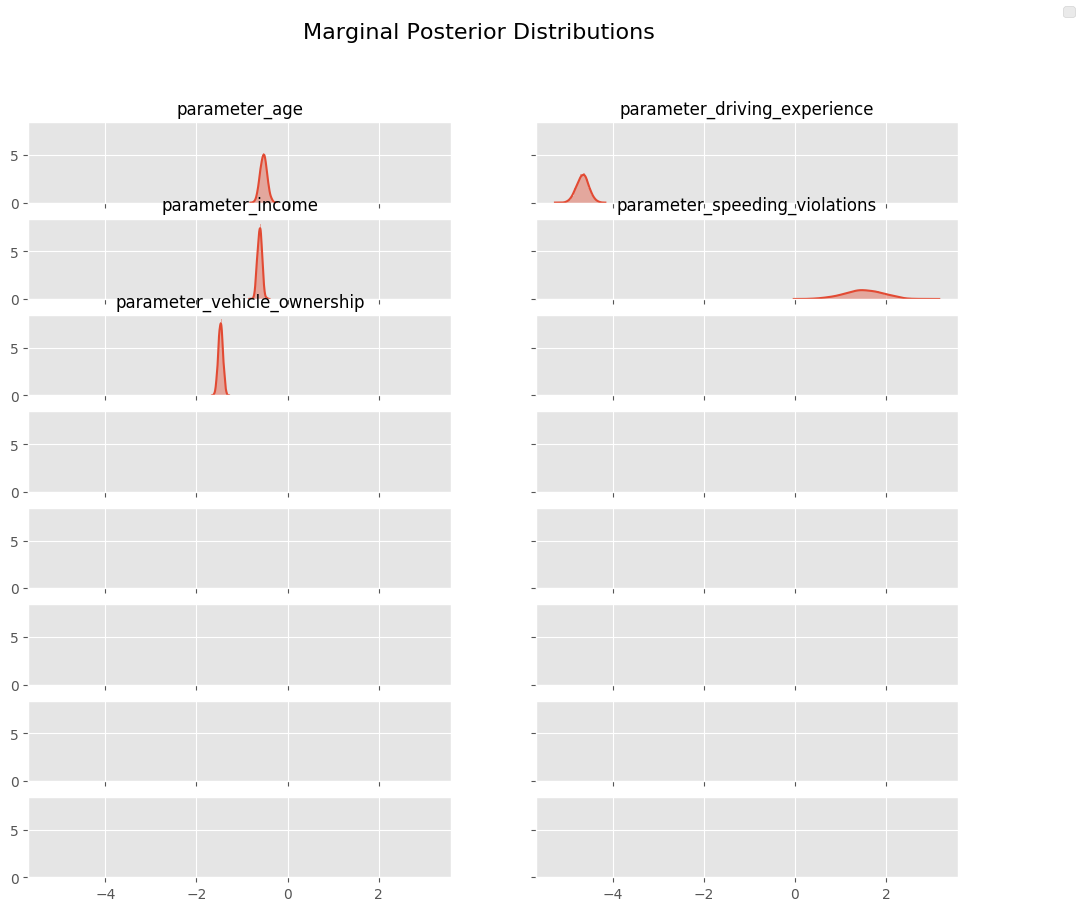

In [335]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle("Marginal Posterior Distributions", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = new_sites[i]
        sns.distplot(svi_samples[site], ax=ax, label="Variational Distribution (MeanField)")
        ax.set_title(site, fontsize=12)
    except IndexError:
        break
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [338]:
summary(svi_samples)



                                      mean       std    median      5.0%     95.0%     n_eff     r_hat
                parameter_age[0]     -0.53      0.08     -0.53     -0.66     -0.41    810.74      1.00
 parameter_driving_experience[0]     -4.66      0.13     -4.65     -4.89     -4.46    946.79      1.00
             parameter_income[0]     -0.61      0.05     -0.61     -0.70     -0.53    922.62      1.00
parameter_speeding_violations[0]      1.51      0.41      1.51      0.83      2.18    812.29      1.00
  parameter_vehicle_ownership[0]     -1.47      0.05     -1.47     -1.55     -1.38   1061.78      1.00
                         bias[0]      1.91      0.03      1.91      1.85      1.96    993.74      1.00




In [339]:
# sense check with standard package implementation of logistic regression
sklearn_model = LogisticRegression(solver="lbfgs")
sklearn_model.fit(X_train_scaled, y_train)
sklearn_model.coef_, sklearn_model.intercept_

(array([[-0.54007062, -4.6586171 , -0.62805188,  1.48653773, -1.49453271]]),
 array([1.89667136]))

In [340]:
def predictive_model(x, y):
    pyro.sample("prediction", Delta(bayes_logistic(x, y)))

In [341]:
trace_pred = TracePredictive(predictive_model, svi_mean_field_posterior, num_samples=1000)

In [342]:
X_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [343]:
posterior_predictive = trace_pred.run(X_tensor, None)

In [344]:
sites = ["prediction", "obs"]
posterior_predictive_samples = {site: EmpiricalMarginal(posterior_predictive, sites=site).enumerate_support().detach().cpu() for site in sites}

In [345]:
subset = posterior_predictive_samples["prediction"][:, :10]
y_pred_sklearn = sklearn_model.predict(X_test_scaled)
subset_sklearn = sklearn_model.predict_proba(X_test_scaled)[:10, 1]

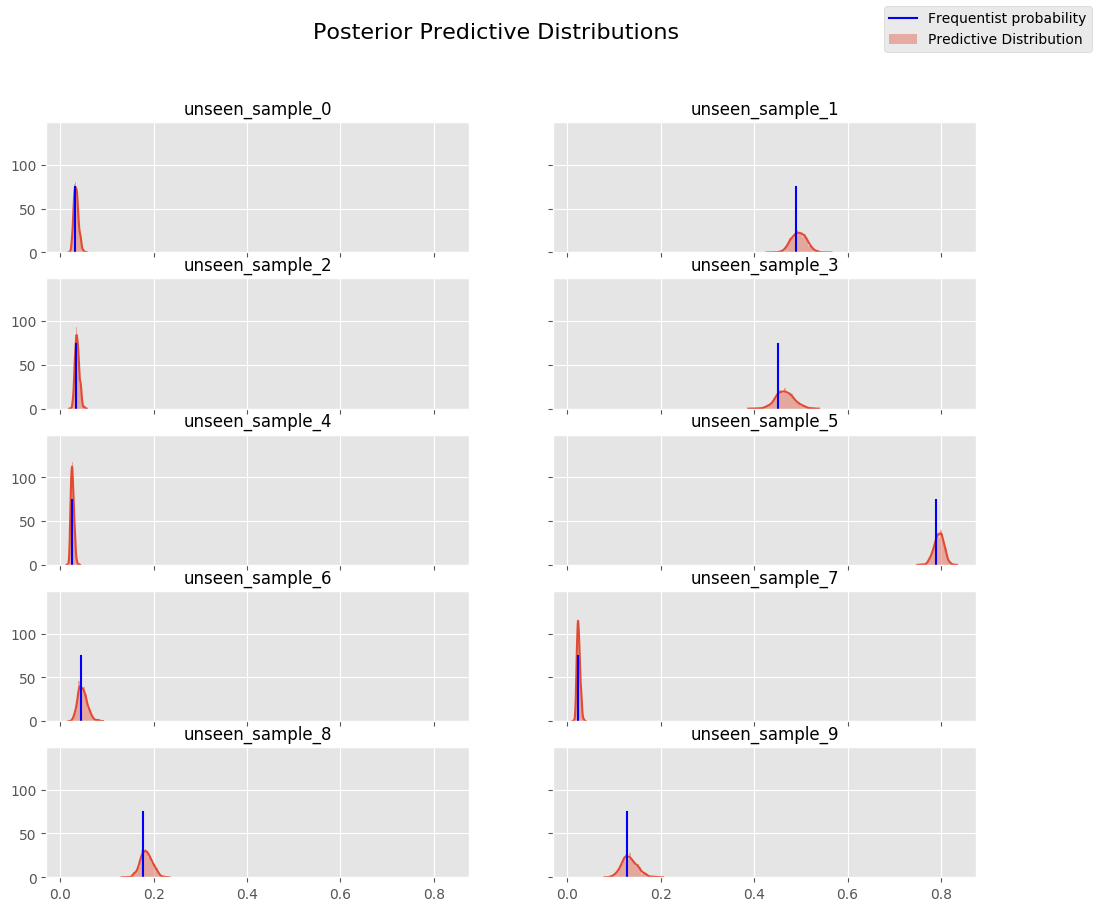

In [350]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle("Posterior Predictive Distributions", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        sns.distplot(subset[:, i], ax=ax, label="Predictive Distribution")
        ax.axvline(subset_sklearn[i], 0, ymax=.5, color='b', label="Frequentist probability")
        ax.set_title(f"unseen_sample_{i}", fontsize=12)
    except IndexError:
        break
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [368]:
y_pred = (posterior_predictive_samples["prediction"].detach().cpu().numpy().mean(0) > .5).astype(int)

In [369]:
confusion_matrix(y_test, y_pred)

array([[983, 140],
       [145, 362]])

In [370]:
confusion_matrix(y_test, y_pred_sklearn)

array([[1003,  120],
       [ 165,  342]])

In [371]:
roc_auc_score(y_test, y_pred)

0.7946689358772377

## Note to lay person

this model serves as both explaining variables' contribution to a claim and predicting new instances considering strength of evidence (probablistic)